# <center>Implementing LDA in Python</center>

## Key Concepts in this Notebook

## Introduction

## Importing the Required Libraries

In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob
from pprint import pprint
import matplotlib.pyplot as plt

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


#spacy
import spacy
from spacy.lang.nl import Dutch
from spacy.lang.nl.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#vis
import pyLDAvis
# import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

## Preparing the Data

In [2]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [2]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/DataSample_DSP_0712.csv', index_col=1) 

In [3]:
df

,Unnamed: 0,re_tll,xml_bewijs,re_bewijs
xml_tll,,,,
NaN,0,[],NaN,[]
NaN,1,[],NaN,[]
NaN,2,[],NaN,[]
NaN,3,[],NaN,[]
NaN,4,[],NaN,[]
...,...,...,...,...
NaN,21650,[],NaN,[]
NaN,21651,[],NaN,[]
NaN,21652,[],NaN,[]


In [4]:
df = df[df['re_tll'] != '[]'][['re_tll']] #re_bewijs

In [5]:
data = [i for i in df['re_tll']]

In [6]:
stopwords = stopwords.words("dutch")
# stopwords.extend(['een', ])

In [7]:
print(stopwords)
print(len(stopwords))

['de', 'en', 'van', 'ik', 'te', 'dat', 'die', 'in', 'een', 'hij', 'het', 'niet', 'zijn', 'is', 'was', 'op', 'aan', 'met', 'als', 'voor', 'had', 'er', 'maar', 'om', 'hem', 'dan', 'zou', 'of', 'wat', 'mijn', 'men', 'dit', 'zo', 'door', 'over', 'ze', 'zich', 'bij', 'ook', 'tot', 'je', 'mij', 'uit', 'der', 'daar', 'haar', 'naar', 'heb', 'hoe', 'heeft', 'hebben', 'deze', 'u', 'want', 'nog', 'zal', 'me', 'zij', 'nu', 'ge', 'geen', 'omdat', 'iets', 'worden', 'toch', 'al', 'waren', 'veel', 'meer', 'doen', 'toen', 'moet', 'ben', 'zonder', 'kan', 'hun', 'dus', 'alles', 'onder', 'ja', 'eens', 'hier', 'wie', 'werd', 'altijd', 'doch', 'wordt', 'wezen', 'kunnen', 'ons', 'zelf', 'tegen', 'na', 'reeds', 'wil', 'kon', 'niets', 'uw', 'iemand', 'geweest', 'andere']
101


In [8]:
def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    nlp = Dutch()
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [9]:
def preprocess(filename):
    text = filename
    text = text.lower()

    text_p = "".join([char for char in text if char not in string.punctuation])
    
    no_numb = ''.join(c for c in text_p if not c.isdigit())
    
    words = word_tokenize(no_numb)
    
    # stop_words = stopwords.words('dutch')
    filtered_words = [word for word in words if word not in stopwords and len(word) > 2]
    
    # Approach One
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    # Approach Two - takes way too long for now - must be optimized
    # lemmatized = [lemmatization(word) for word in filtered_words]
    # lemmatized = lemmatization(filtered_words) 
    
    return lemmatized

In [10]:
data_words = []
for i in data:
    a = preprocess(i)
    data_words.append(a)

# Getting Data

In [11]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100) # min_counts = Minimum counts that it is being taken into consideration
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)


In [12]:
print (data_bigrams_trigrams[2])

['tenlasteleggingnnnde_verdenking_komt', 'wijziging_tenlastelegging', 'januari', 'kort_zakelijk_weergegeven', 'neer', 'verdachte', 'nnfeit', 'primair', 'periode', 'december', 'december', 'anderen', 'alleen', 'ghb', 'mdma_xtc', 'amfetamine', 'lsd', 'cocaïne', 'gehandeld', 'drug', 'opzettelijk', 'aanwezig_gehad', 'wel', 'subsidiair', 'hieraan_medeplichtig', 'nnfeit', 'december', 'anderen', 'alleen', 'diverse', 'soorten', 'drug', 'bereid', 'bewerkt', 'verwerkt', 'wel', 'opzettelijk', 'aanwezig_gehad', 'nnnnvoluit_luidt', 'tenlastelegging', 'verdachte', 'datnnn', 'tijdstippen', 'omstreeks', 'periode', 'december', 'december', 'enschede', 'enof', 'almelo', 'ieder', 'geval', 'nederland_tezamen_vereniging', 'anderen', 'althans', 'alleen', 'opzettelijk', 'verkocht', 'enof', 'afgeleverd', 'enof', 'verstrekt', 'enof', 'vervoerd', 'elk', 'geval', 'opzettelijk', 'aanwezig', 'gehadeen', 'hoeveelheid_materiaal_bevattende', 'ghb', 'zijnde', 'ghb', 'enofeen_hoeveelheid_materiaal_bevattende', 'mdma_xtc'

In [13]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


In [14]:
pprint(id2word[0])
print((corpus)[0])

'aangeefster'
[(0, 4), (1, 1), (3, 1), (5, 1), (6, 4), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (14, 1), (15, 1), (17, 1), (18, 2), (20, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (29, 1), (32, 1), (34, 1), (35, 3), (36, 1), (37, 2), (38, 4), (39, 2), (40, 1), (41, 2), (42, 1), (43, 3), (44, 1), (46, 1), (47, 2), (48, 3), (50, 2), (51, 3), (53, 2), (54, 2), (55, 1), (56, 1), (57, 1), (58, 10), (59, 1), (60, 1), (61, 1), (62, 1), (64, 2), (65, 3), (66, 2), (67, 1), (69, 1), (70, 1), (71, 1), (73, 1), (74, 1), (75, 4), (76, 1), (77, 10), (78, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 5), (87, 3), (88, 1), (90, 1), (91, 1), (92, 2), (93, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (102, 1), (103, 1), (105, 1), (106, 1), (107, 2), (108, 4), (109, 1), (110, 1), (112, 2), (113, 1), (114, 1), (115, 1), (116, 4), (123, 1), (124, 1), (126, 1), (127, 4), (128, 1), (130, 1), (131, 4), (133, 1), (137, 1), (139, 3), (140, 1), (142, 1), (146, 1), (

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aangeefster', 4),
  ('aangehouden', 1),
  ('aanzien_bewijsnnnnnnde', 1),
  ('afgesproken', 1),
  ('afspraak', 4),
  ('arnhem', 1),
  ('arnhemzuid', 1),
  ('begin', 1),
  ('beiden', 1),
  ('bellen', 1),
  ('beneden', 1),
  ('bevondnnnnnhet', 1),
  ('beweerdelijk', 1),
  ('boekarest', 1),
  ('bus', 2),
  ('daarvoor', 1),
  ('desbevoegd', 1),
  ('dient_vrijgesproken', 1),
  ('discussie_staat', 1),
  ('dochter', 1),
  ('duitsland', 3),
  ('düsseldorf', 1),
  ('echtgenote', 1),
  ('einde', 1),
  ('feitennnop_grond', 1),
  ('gaan', 3),
  ('gebeld', 1),
  ('gebezigd', 2),
  ('geboren_geboortedatum_geboorteplaats', 4),
  ('gegaan', 2),
  ('gehaald', 1),
  ('gekomen', 2),
  ('genaamd', 1),
  ('genomen', 3),
  ('gestapt', 1),
  ('getrouwd', 1),
  ('getuige', 2),
  ('gezag', 3),
  ('hadden', 2),
  ('halen', 3),
  ('henhaar', 2),
  ('hongarije', 2),
  ('hoorde', 1),
  ('huis', 1),
  ('ingesproken', 1),
  ('kinderen', 10),
  ('kleding', 1),
  ('kledingtoiletartikelen', 1),
  ('kleve', 1),
  ('k

In [16]:
#id2word = corpora.Dictionary(all_texts)

# corpus = []
# for text in data_words:
#     new = id2word.doc2bow(text)
#     corpus.append(new)

# print (corpus[0][0:20])

# word = id2word[[0][:1][0]]
# print (word)

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [18]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.049*"medeverdachte" + 0.031*"hof" + 0.027*"benadeelde" + 0.024*"rechtbank" + 0.020*"getuige" + 0.018*"zag" + 0.017*"uur" + 0.016*"verklaard" + 0.016*"auto" + 0.016*"verbalisant"'), (1, '0.014*"the" + 0.013*"zoals" + 0.013*"oogmerk" + 0.011*"internationale" + 0.008*"jund_alaqsa" + 0.006*"ahrar_alsham" + 0.006*"terroristisch" + 0.006*"organisatie" + 0.006*"syrië" + 0.005*"organisaties"'), (2, '0.018*"weg" + 0.012*"bestuurder" + 0.012*"reed" + 0.010*"schip" + 0.010*"personenauto" + 0.010*"gevolg" + 0.009*"tijdig" + 0.008*"snelheid" + 0.007*"werknemers" + 0.007*"gereden"'), (3, '0.185*"enof" + 0.022*"althans" + 0.018*"slachtoffer" + 0.015*"enofnufd" + 0.014*"geval" + 0.014*"elk" + 0.012*"naam" + 0.009*"telkens" + 0.008*"woning" + 0.008*"ander"'), (4, '0.277*"naam" + 0.048*"medeverdachte" + 0.046*"september" + 0.045*"kinderen" + 0.021*"rechtbank" + 0.019*"verklaard" + 0.016*"zoons" + 0.012*"geld" + 0.007*"uur" + 0.007*"verzoek"'), (5, '0.131*"enof" + 0.029*"bedrijf" + 0.020*"verdach

In [19]:
test_doc = corpus[-1]

vector = lda_model[test_doc]
print (vector)

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    sub_li.reverse()
    return (sub_li)
new_vector = Sort(vector)
print (new_vector)

[(2, 0.022763673), (3, 0.7667555), (4, 0.08246679), (6, 0.10881156), (7, 0.011538684)]
[(3, 0.7667555), (6, 0.10881156), (4, 0.08246679), (2, 0.022763673), (7, 0.011538684)]


In [20]:
# lda_model.save("/Users/dj/Documents/GitHub/DSP/topic_modeling_textbook-main/models/test_model.model")

In [21]:
# new_model = gensim.models.ldamodel.LdaModel.load("models/test_model.model")

In [22]:
test_doc = corpus[-1]

vector = lda_model[test_doc] # lda_model can be replaced by new_model
print (vector)

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    sub_li.reverse()
    return (sub_li)
new_vector = Sort(vector)
print (new_vector)

[(2, 0.022763668), (3, 0.7667548), (4, 0.08246695), (6, 0.10881186), (7, 0.011538683)]
[(3, 0.7667548), (6, 0.10881186), (4, 0.08246695), (2, 0.022763668), (7, 0.011538683)]


## Vizualizing the Data

In [23]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.404985  0.066322       1        1  39.574874
0     -0.081317 -0.396464       2        1  19.708900
5     -0.335454 -0.144597       3        1  16.580991
6     -0.184378  0.395446       4        1  11.794658
4      0.251345 -0.283677       5        1   4.236181
2      0.324949  0.045823       6        1   4.126443
7      0.185776  0.310272       7        1   2.701643
1      0.062072 -0.051129       8        1   0.909500
8      0.077009  0.039396       9        1   0.253094
9      0.104983  0.018609      10        1   0.113718, topic_info=                    Term          Freq         Total Category  logprob  \
757          slachtoffer  10564.000000  10564.000000  Default  10.0000   
33                  enof  29372.000000  29372.000000  Default   9.0000   
77                  naam   5148.000000   5148.000000  Default   8.0000   
604        medeverdachte   3848.000000   3848.000000  Default   7.0000   
0            aangeefster   1056.000000   1056.000000  Default   6.0000   
...                  ...           ...           ...      ...      ...   
11976  tenlasteleggingen      0.675072      1.398404  Topic10  -6.2556   
3398               ervan      0.652737      1.376025  Topic10  -6.2892   
5466            verdenkt      0.612045      1.335150  Topic10  -6.3536   
1902            bestuurd      0.809587      3.918116  Topic10  -6.0739   
5076          onachtzaam      0.835576      8.640343  Topic10  -6.0423   

       loglift  
757    10.0000  
33      9.0000  
77      8.0000  
604     7.0000  
0       6.0000  
...        ...  
11976   6.0509  
3398    6.0334  
5466    5.9992  
1902    5.2024  
5076    4.4431  

[173 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
0          7  0.999643   aangeefster
255        2  0.974779  aangetroffen
255        5  0.024941  aangetroffen
256        4  0.998971      aangever
8625       8  0.950685  ahrar_alsham
...      ...       ...           ...
21230      5  0.995919         zoons
942        1  0.360130           één
942        3  0.607719           één
942        6  0.011254           één
942        7  0.019439           één

[235 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 7, 5, 3, 8, 2, 9, 10])

In [ ]:
# Each bubble represents a topic - the larger a bubble, the more important the topic
# Good model has hardly any overlapping topics and scattered all over the quadrant




# Advanced Analysis of Model

In [43]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.494848268970168


/opt/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/opt/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))



Coherence Score:  nan


In [57]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values

In [58]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=40, step=6)

In [63]:
coherence_values

[nan, nan, nan, nan, nan, nan, nan]

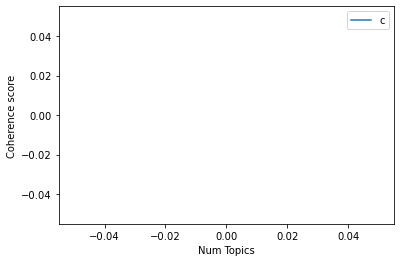

In [61]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()